In [1]:
import sys
sys.path += ["/home/jacopo.lenti/Projects/learning-od-step-by-step/src"]

from opinion_dynamics_models_estimation import simulate_BC
import pandas as pd
import opinion_dynamics_models_estimation as oe


from MSM_calibrator import calibrate_params_ABM
from MSM_simulators import BC_simulator, BC_simulator_positive_observations, BC_simulator_X_evidences, BC_simulator_X_evidences_backfire
import MSM_simulators
import json
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import repeat_function
from importlib import reload
from scipy.special import expit as sigmoid

In [2]:
def complete_calibration(simulator_class, X, edges, evidences, calibration_batches, N, mu, epsilon, rho):
    if simulator_class == BC_simulator:
        simulator = simulator_class(X0 = X[0], edges = edges, N = N, mu = mu, real_epsilon = epsilon, rho = rho, seed = None)
        simulator_name = "full_observed"
    elif simulator_class == BC_simulator_positive_observations:
        simulator = simulator_class(X0 = X[0], edges = edges, N = N, mu = mu, real_epsilon = epsilon, rho = rho, seed = None)
        simulator_name = "partial_observed"
    elif simulator_class ==  BC_simulator_X_evidences:
        simulator = simulator_class(evidences = evidences, edges = edges, N = N, mu = mu, real_epsilon = epsilon, rho = rho, seed = None)
        simulator_name = "noisy_observed"
        
    calibration_df, time_calibration = calibrate_params_ABM(simulator, 
                                                            calibration_batches = calibration_batches)
    
    return {"epsilon_msm": calibration_df["epsilon"][0], "calibration_batches": calibration_batches,
            "real_epsilon": epsilon, "time_calibration": time_calibration, "simulator_name": simulator_name}

    

    

In [20]:
nested_simulations = []
mu = 0.1
rho = 16

for _ in range(30):
    np.random.seed(None)
    epsilon = np.random.random() / 2
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "edge_per_t": 16, 
                                                       "evidences_per_t": 8, 
                                                       "parameters": [epsilon, mu, rho]}, 
                                                      {"T": [32, 64, 128],},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [complete_calibration, 
                                                      {"N": 100,
                                                       "mu":mu,
                                                       "epsilon":epsilon,
                                                       "rho":rho, 
                                                      },
                                                      {
                                                       "calibration_batches": [25, 50, 100, 200, 400, 800],
                                                       "simulator_class": [BC_simulator, BC_simulator_positive_observations, BC_simulator_X_evidences]},1],
                                                     verbose1 = False, verbose2 = True
                               )
    msm_tuning = pd.DataFrame(nested_simulations).assign(distance_epsilon = lambda x: np.abs(x["epsilon_msm"] - x["real_epsilon"]))\
    .drop(["parameters", "simulator_class"], axis = 1)
    msm_tuning.to_csv(f"/home/jacopo.lenti/Projects/learning-od-step-by-step/data/tuning_calibration_batches_all_simulators_230801.csv", index = None)

100%|███████████████████████████████████████| 18/18 [00:00<00:00, 260336.11it/s]


<AxesSubplot:xlabel='calibration_batches', ylabel='distance_epsilon'>

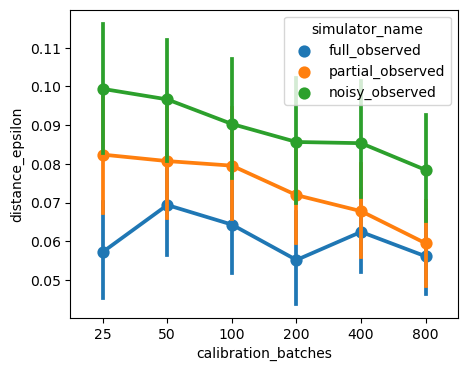

In [32]:
fig, axes = plt.subplots(ncols = 1, nrows = 1, figsize = (5, 4))


sns.pointplot(data = msm_tuning, x = "calibration_batches", 
              hue = "simulator_name", y =  "distance_epsilon")

In [34]:
msm_tuning.groupby(["simulator_name", "T", "calibration_batches"]).mean()

N  edge_per_t  evidences_per_t  \
simulator_name   T   calibration_batches                                       
full_observed    32  25                   100.0        16.0              8.0   
                     50                   100.0        16.0              8.0   
                     100                  100.0        16.0              8.0   
                     200                  100.0        16.0              8.0   
                     400                  100.0        16.0              8.0   
                     800                  100.0        16.0              8.0   
                 64  25                   100.0        16.0              8.0   
                     50                   100.0        16.0              8.0   
                     100                  100.0        16.0              8.0   
                     200                  100.0        16.0              8.0   
                     400                  100.0        16.0              8.0   
                     800                  100.0        16.0              8.0   
                 128 25                   100.0        16.0              8.0   
                     50                   100.0        16.0              8.0   
                     100                  100.0        16.0              8.0   
                     200                  100.0        16.0              8.0   
                     400                  100.0        16.0              8.0   
                     800                  100.0        16.0              8.0   
noisy_observed   32  25                   100.0        16.0              8.0   
                     50                   100.0        16.0              8.0   
                     100                  100.0        16.0              8.0   
                     200                  100.0        16.0              8.0   
                     400                  100.0        16.0              8.0   
                     800                  100.0        16.0              8.0   
                 64  25                   100.0        16.0              8.0   
                     50                   100.0        16.0              8.0   
                     100                  100.0        16.0              8.0   
                     200                  100.0        16.0              8.0   
                     400                  100.0        16.0              8.0   
                     800                  100.0        16.0              8.0   
                 128 25                   100.0        16.0              8.0   
                     50                   100.0        16.0              8.0   
                     100                  100.0        16.0              8.0   
                     200                  100.0        16.0              8.0   
                     400                  100.0        16.0              8.0   
                     800                  100.0        16.0              8.0   
partial_observed 32  25                   100.0        16.0              8.0   
                     50                   100.0        16.0              8.0   
                     100                  100.0        16.0              8.0   
                     200                  100.0        16.0              8.0   
                     400                  100.0        16.0              8.0   
                     800                  100.0        16.0              8.0   
                 64  25                   100.0        16.0              8.0   
                     50                   100.0        16.0              8.0   
                     100                  100.0        16.0              8.0   
                     200                  100.0        16.0              8.0   
                     400                  100.0        16.0              8.0   
                     800                  100.0        16.0              8.0   
                 128 25                   100.

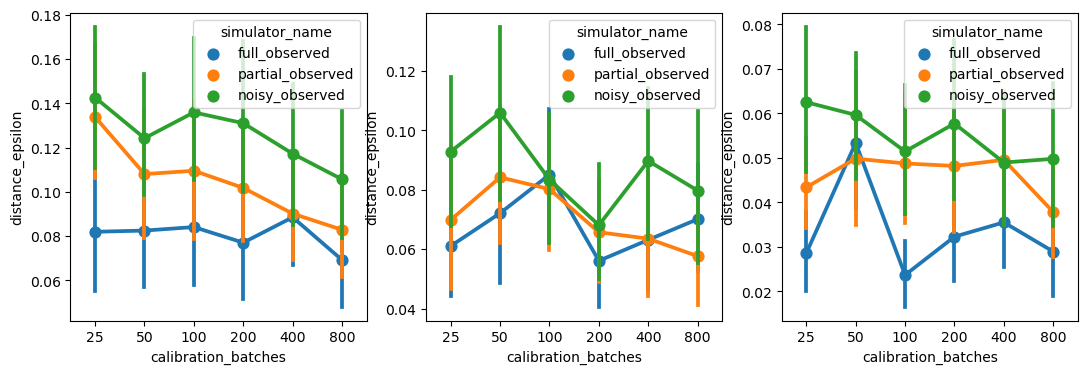

In [31]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (13, 4))

for ax, T_ in zip(axes, [32, 64, 128]):
    sns.pointplot(data = msm_tuning.query("T == @T_"), x = "calibration_batches", 
                  hue = "simulator_name", y =  "distance_epsilon", ax = ax)

In [26]:
pd.DataFrame(nested_simulations).drop("parameters", axis = 1)\
.assign(distance_epsilon = lambda x: np.abs(x["epsilon_msm"] - x["real_epsilon"]))\
.groupby("real_epsilon").var()

,N,T,edge_per_t,evidences_per_t,calibration_batches,epsilon_msm,time_calibration,distance_epsilon
real_epsilon,,,,,,,,
0.002325,0.0,0.0,0.0,0.0,93000.0,0.000004,333.945458,2.268992e-06
0.008813,0.0,0.0,0.0,0.0,93000.0,0.000388,335.313865,3.878433e-04
0.010012,0.0,0.0,0.0,0.0,93000.0,0.000017,3277.555606,1.728148e-05
0.017731,0.0,0.0,0.0,0.0,93000.0,0.000086,1002.525351,8.555782e-05
0.024391,0.0,0.0,0.0,0.0,93000.0,0.000016,341.435292,1.606613e-05
...,...,...,...,...,...,...,...,...
0.480913,0.0,0.0,0.0,0.0,93000.0,0.000001,1821.005744,1.349070e-06
0.487633,0.0,0.0,0.0,0.0,93000.0,0.000003,2657.562569,9.892845e-07
0.495211,0.0,0.0,0.0,0.0,93000.0,0.000003,318.292840,2.977370e-06
